In [131]:
import numpy as np          
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd       
import seaborn as sns       
import sklearn   

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Постановка задачи
1. Обучить на ваших данных полносвязную (неглубокую) нейронную сеть.
1. Попробуйте 1-2 скрытых слоя. 
1. Постройте графики зависимости ошибки на обучающей выборке и тестовой выборках от параметра alpha и от количества нейронов.
1. Наблюдается ли переобучение/недообучение?

# 1. Чтение данных

In [132]:
df = pd.read_csv('apartament_data.csv')
print(f'Число сэмлов = {df.shape[0]}')
print(f'Число признаков = {df.shape[1]}')
print(f'Типы признаков:')
[print('\tтип:', ttype, '\tчисло признаков:', num) 
    for ttype, num in zip(df.dtypes.value_counts().index, df.dtypes.value_counts())]
pass

Число сэмлов = 5891
Число признаков = 30
Типы признаков:
	тип: float64 	число признаков: 16
	тип: int64 	число признаков: 8
	тип: object 	число признаков: 6


#### Бинаризуем категориальные признаки

In [133]:
object_cols = df.select_dtypes("object").columns
for col in object_cols:
    df = pd.concat((df, pd.get_dummies(df[col])), axis=1)
    df = df.drop([col], axis=1)
df.head()

,SalePrice,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_APT,N_manager,...,5min~10min,no_bus_stop_nearby,Bangoge,Banwoldang,Chil-sung-market,Daegu,Kyungbuk_uni_hospital,Myung-duk,Sin-nam,no_subway_nearby
0,141592,2006,2007,8,814,3,111.0,184.0,3.0,3.0,...,0,0,0,0,0,0,1,0,0,0
1,51327,1985,2007,8,587,8,80.0,76.0,1.0,2.0,...,1,0,0,0,0,1,0,0,0,0
2,48672,1985,2007,8,587,6,80.0,76.0,1.0,2.0,...,1,0,0,0,0,1,0,0,0,0
3,380530,2006,2007,8,2056,8,249.0,536.0,6.0,5.0,...,0,0,0,0,0,0,0,0,1,0
4,221238,1993,2007,8,1761,3,523.0,536.0,8.0,8.0,...,0,0,0,0,0,0,0,1,0,0


#### Преобразуем цену квартиры в ее "престижность" - Сводим задачу регерессии к задаче классификации.

Разобьем дипазон цен за квартиры на 3 диапазона с использованием квантилей 1-го и 3-го уровней тренировочных цен.

In [134]:
price = df.SalePrice
first_q = price.quantile(0.25)
third_q = price.quantile(0.75)
# Разделение квартир на классы престижности: low, middle и hight для ВСЕХ сэмплов 
# используя квантили только ТРЕНИРОВОЧНЫХ данных
prestige = np.asarray(["middle"] * len(df))
prestige[list(df.SalePrice <= first_q)] = "low"
prestige[list(df.SalePrice > third_q)] = "hight"
# Добавление нового столбца prestige и удаление старого price
df.insert(0, "prestige", pd.Series(prestige))
df['prestige'] = df['prestige'].astype('category')
df = df.drop(['SalePrice'], axis=1)
# Проверка что наши классы несбалансированны (хотя это итак очевидно)
print("Доли квартир в общей выборке:")
df['prestige'].value_counts() 

Доли квартир в общей выборке:


middle    2953
low       1474
hight     1464
Name: prestige, dtype: int64

# 2. Разбиение данных на обучающую и тестовую выборки
Поскольку наши классы несбалансированны то используем параметр *stratify*, чтобы доли классов в тесте и трейне были одинаковыми. 

In [135]:
df_train, df_test = train_test_split(df,  test_size=0.2, random_state=42, stratify=df.prestige)
print(f"N_train = {len(df_train)}\nN_test = {len(df_test)}")

X_train = df_train.drop(['prestige'], axis=1)
y_train = np.asarray([1] * len(df_train))
y_train[df_train.prestige == "low"] = 0
y_train[df_train.prestige == "hight"] = 2

X_test = df_test.drop(['prestige'], axis=1)
y_test = np.asarray([1] * len(df_test))
y_test[df_test.prestige == "low"] = 0
y_test[df_test.prestige == "hight"] = 2

N_train = 4712
N_test = 1179


#### Cтандартизация

In [136]:
mean = X_train.mean(axis = 0)
std = X_train.std(axis = 0)

X_train = (X_train - mean) / std
X_test =  (X_test  - mean) / std

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

## 3 Подбор гиперпараметров
В качестве алгоритма оптимизации выберем наиболее популярный и эффективный алгоритм **Адам**  
В качестве функции активации выберем **ReLu**  
В качетве метрики оценки классификатора возьмем **Fscore** - среднее гармоническое точности и полноты.  
Поскольку классы не сбалансированны, то при вычислении Fscore установим параметр average='weighted', чтобы спарведливо оценивать точность классификации для каждого класса (вычисляем метрики(accuracy/precision) для каждой класса и находим их средневзвешенные значения)

## 3.1 Подбор числа нейронов в однослойном классификаторе

In [139]:
hidden_layer_size = np.linspace(1, 40, 40)
hidden_layer_size = hidden_layer_size.astype(int)
test_err, train_err = [], []
train_f1, test_f1 = [], []

for size in tqdm(hidden_layer_size):
    model = MLPClassifier(hidden_layer_sizes=(size,), 
                          solver='adam', activation='relu', max_iter=1000, random_state=13)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_f1.append(f1_score(y_train, y_train_pred, average='weighted'))
    test_f1.append(f1_score(y_test, y_test_pred, average='weighted'))

100%|███████████████████████████████████████████| 40/40 [04:18<00:00,  6.45s/it]


Train: Минимальная ошибка=0.039261460101867575, при числе нейронов=40
Test: Минимальная ошибка=0.0364715860899067, при числе нейронов=22


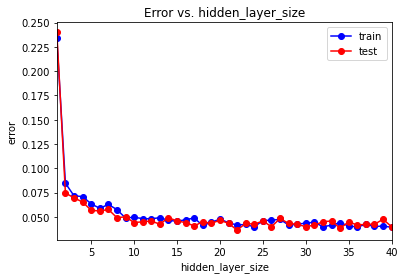

In [85]:
plt.plot(hidden_layer_size, train_err, 'b-o', label = 'train')
plt.plot(hidden_layer_size, test_err, 'r-o', label = 'test')
plt.xlim([np.min(hidden_layer_size), np.max(hidden_layer_size)])
plt.title('Error vs. hidden_layer_size')
plt.xlabel('hidden_layer_size')
plt.ylabel('error')
plt.legend()

print(f"Train: Минимальная ошибка={np.min(train_err)}, при числе нейронов={hidden_layer_size[np.argmin(train_err)]}")
print(f"Test: Минимальная ошибка={np.min(test_err)}, при числе нейронов={hidden_layer_size[np.argmin(test_err)]}")

Train: Максимальный fscore=0.9607349767736243, при числе нейронов=40
Test: Максимальный fscore=0.9635204129599413, при числе нейронов=22


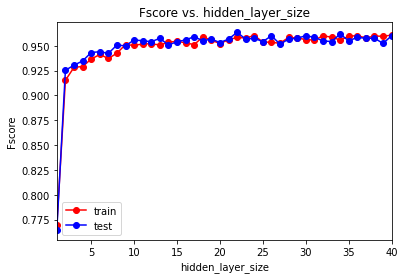

In [86]:
plt.plot(hidden_layer_size, train_f1, 'r-o', label = 'train')
plt.plot(hidden_layer_size, test_f1, 'b-o', label = 'test')
plt.xlim([np.min(hidden_layer_size), np.max(hidden_layer_size)])
plt.title('Fscore vs. hidden_layer_size')
plt.xlabel('hidden_layer_size')
plt.ylabel('Fscore')
plt.legend()

print(f"Train: Максимальный fscore={np.max(train_f1)}, при числе нейронов={hidden_layer_size[np.argmax(train_f1)]}")
print(f"Test: Максимальный fscore={np.max(test_f1)}, при числе нейронов={hidden_layer_size[np.argmax(test_f1)]}")

## 3.2 Подбор числа нейронов в двухслойном классификаторе

In [143]:
n = 10
sizes = np.linspace(1, 40, n).astype(int)
test_err = np.zeros((n, n))
train_err = np.zeros((n, n))
train_f1 = np.zeros((n, n))
test_f1 = np.zeros((n, n))

for i, size1 in tqdm(enumerate(sizes)):
    for j, size2 in enumerate(sizes):
        model = MLPClassifier(hidden_layer_sizes=(size1, size2, ), 
                              solver='adam', activation='relu', max_iter=1000, random_state=13)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_err[i][j] = np.mean(y_train != y_train_pred)
        test_err[i][j] = np.mean(y_test != y_test_pred)

        train_f1[i][j] = f1_score(y_train, y_train_pred, average='weighted')
        test_f1[i][j] = f1_score(y_test, y_test_pred, average='weighted')

10it [09:33, 57.31s/it]


Train: Минимальная ошибка = 0.027801358234295415, при числе нейронов=(9, 8)
Test: Минимальная ошибка = 0.0364715860899067, при числе нейронов=(4, 5)


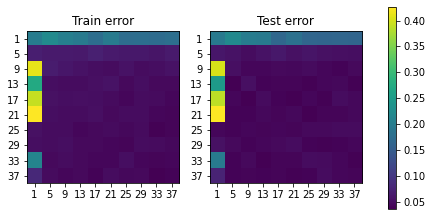

In [145]:
plt.subplot(121)
plt.title("Train error")
plt.imshow(train_err)
plt.xticks(np.arange(10), np.arange(1, 40, 4))
plt.yticks(np.arange(10), np.arange(1, 40, 4))

plt.subplot(122)
plt.title("Test error")
plt.imshow(test_err)
plt.xticks(np.arange(10), np.arange(1, 40, 4))
plt.yticks(np.arange(10), np.arange(1, 40, 4))

cax = plt.axes([0.96, 0.15, 0.02, 0.7])
plt.colorbar(cax=cax)

train_min_loss_sizes = np.where(train_err == np.min(train_err))
print(f"Train: Минимальная ошибка = {np.min(train_err)}, при числе нейронов=(" \
      f"{train_min_loss_sizes[0][0]}, {train_min_loss_sizes[1][0]})")

test_min_loss_sizes = np.where(test_err == np.min(test_err))
print(f"Test: Минимальная ошибка = {np.min(test_err)}, при числе нейронов=(" \
      f"{test_min_loss_sizes[0][0]}, {test_min_loss_sizes[1][0]})")

Train: Максимальный fscore = 0.9722014883026524, при числе нейронов=(9, 8)
Test: Максимальный fscore = 0.9635336460888183, при числе нейронов=(5, 6)


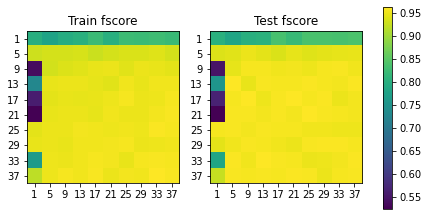

In [146]:
plt.subplot(121)
plt.title("Train fscore")
plt.imshow(train_f1)
plt.xticks(np.arange(10), np.arange(1, 40, 4))
plt.yticks(np.arange(10), np.arange(1, 40, 4))

plt.subplot(122)
plt.title("Test fscore")
plt.imshow(test_f1)
plt.xticks(np.arange(10), np.arange(1, 40, 4))
plt.yticks(np.arange(10), np.arange(1, 40, 4))

cax = plt.axes([0.95, 0.15, 0.02, 0.7])data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAawAAADYCAYAAAC3DNfPAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/MnkTPAAAACXBIWXMAAAsTAAALEwEAmpwYAAAomklEQVR4nO3deZwdVZ338c+3O52EkIQEAgoJhCBhG1l0GHBAEFwgMj4ExSUZR8EFZIaouD3CyAuYMDziuD0zI6NEE6IOi7xAeKJmgMwAoiMySTQsCQRDBEkAIYQlbEmn+/v8UdWm0vRduup2971dv/frVa/cW1Xnnrq3fzfn1qlT5yfbhBBCCM2ubagPIIQQQqhHNFghhBBaQjRYIYQQWkI0WCGEEFpCNFghhBBaQjRYIYQQWsKIoT6AEEIIg+/E43f00xu7qu6z/J7NN9ueMUiHVFM0WCGEUEIbNnZx181Tqu7TsftDkwbpcOoSXYIhhFBKpsvdVZd6SJohabWkNZLO7WP7VEn/JekeSbdLmpLZ1iVpRbosqlVXnGGFEEIJGdhK9S7BWiS1A5cB7wDWAUslLbK9KrPb14Af2P6+pLcCXwY+lG572fZh9dYXZ1ghhFBCxnS5+lKHI4A1ttfa3gJcA8zstc9BwK3p49v62F63aLBCCKGkunHVpQ6TgUczz9el67LuBt6TPn43ME7SLunz0ZKWSfq1pFNqVRZdgiGEUEIGOql5nWqSpGWZ5/Nsz+tnVZ8HviXpdOAOYD38qS9yqu31kvYBbpV0r+2HKr1QNFghhFBChnq6/TbYPrzK9vXAnpnnU9J12+qxHyM9w5I0FjjV9rPptvXpv2sl3Q68AajYYEWX4ACS9B+STstZdv905MwmSZ9q9LGFMNgkvVvSo5JekPSGoT6eAN01ljosBaZLmiZpJDAL2G60n6RJknramvOABen6iZJG9ewDHA1kB2u8SjRYvaRfpp6lW9LLmecf7M9r2X6n7e/nPJT/Ddxme5ztf8n5GiH0qZFxnr7e7ZI+XmO3rwFzbI+1/dt8Rx4axZiuGkvN17C3AnOAm4H7gWttr5Q0V9LJ6W7HAaslPQi8BrgkXX8gsEzS3SSDMS7tNbrwVaJLsBfbY3seS3oY+Ljt/+y9n6QR6R9roEwlGXEzKAbh/YQmUm+cN9hUYOUA1wGAJAGy67yZqIRs6GxA/l7bi4HFvdZdkHl8HXBdH+V+BRzcn7riDKtOko6TtE7SFyU9AVyRntL+VNJTkp5JH2dvivvTr05Jp0v6paSvpfv+XtI7K9R1K3A8yYXKFyTtJ+kkSavSLsL1kj6f2X9m2n34vKSHJM1I1+8haZGkjelNfWdkylwk6TpJ/y7peeB0STtJmi/p8bSOf0zvswglIalN0rlpHD0t6VpJO6fbRqfx8rSkZyUtlfQaSZcAx7AtXr/V6zVHSXoBaAfulvRQuv6LaZxtUnLj6dvS9e2S/j49hk2SlkvaM912VFrvc+m/R2XquV3SJZL+G3gJ2EfSAZKWpN+B1ZLePxifY2sQXTWWZhMNVv+8FtiZ5JfimSSf3xXp872Al4FvVSwNRwKrgUnAPwHz01+C27H9VuAXbOs+eRCYD3zC9jjg9aT3NUg6AvgB8AVgAnAs8HD6UteQDDPdA3gv8H+U3LjXYybJL58JwJXAQmArsC/Jxc8TgFrdPGF4+SRwCvAWkrh5huTGUIDTgJ1ILrLvApxFcuPnl9g+XudkX9D25swZ3aG2Xydpf5KupL9IY/pEtsXtZ4HZwEnAeOCjwEtpw/kz4F/S+r8B/EzbhkhDckPqmcA44ClgCXAVsBvJ9ZV/k3RQkQ9ouDDQ7epLs4kGq3+6gQvTL+DLtp+2fb3tl2xvIumbfUuV8o/Y/q7tLuD7wO4kfbr16AQOkjTe9jO2f5Ou/xiwwPYS292219t+IP1FejTwRduv2F4BfA/4cOY177R9Y9ptMp7kP4hzbL9o+0ngmyRf8lAeZwFfsr3O9mbgIuC9kkaQxOAuwL62u2wvt/18znq6gFEkMd1h++HMcOaPA+fbXu3E3bafBv4K+J3tH9reavtq4AHgf2Ved6HtlWn39gzgYdtXpPv/FrgeeF/OYx524gxreHvK9is9TySNkXS5pEfSbrU7gAlVutGe6Hlg+6X04dgK+/Z2KkmD8oikn0v6y3T9nvQ9DHQPYGPakPZ4hO1v6sve8DcV6AAeT7t7ngUuJ/llGspjKnBDJgbuJ2lcXgP8kOTi+jWSHpP0T5I68lRiew1wDkmD+KSkayTtkW6uFtOP9FpXK6aP7Hkv6fv5IElPSekZ6HRb1aXZNN8RNbfeJ8mfA/YHjrQ9nqQ7Dmj8TxPbS23PJGlAbgSuTTc9CryujyKPATtLGpdZtxfb3yORfT+PApuBSbYnpMt423/WqPcQWsKjwDszMTDB9uj0zL3T9j/YPgg4CngX287Y+92BZPsq228maVgMfCVzDJViemqvdbVi+ue93stY23/b32MdjkycYZXNOJLrVs+m/esXDkQlkkZK+qCknWx3As+z7TaJ+cBHJL0tvWA+WdIBth8FfgV8Ob1YfghJ9+G/91WH7ceBW4CvSxqfvtbrJFXr4gzDz3eASyRNBZC0q6SZ6ePjJR2c9iA8T9JF2BOHfwT2qbcSJfcZvlXJfTivkHyPel7re8DFkqYrcUh6nWoxsJ+kv5Y0QtIHSOap+2mFan6a7v8hSR3p8heSDuzH5zFsGdFFW9Wl2TTfEbWW/wvsAGwAfg3cNIB1fQh4OO16PIukawPb/wN8hOR603PAz9n2K3Q2sDfJL9MbSK6/VRu6/GFgJMnNe8+QDMjYvdFvJDS1fya58fMWSZtI4vrIdNtrSWLieZKuwp+TdBP2lHuvkhGw9dw3OAq4lOS78wRJz8F56bZvkPQg3JLWNR/YIb2O9S6Sno2nSe5VfJftDX1VkHaHn0ByHfaxtJ6vpHUHoNuqujQbub4ZeUMIIQwjBxwy2t9dVD2B47HTHlpeY2qmQRU3DocQQgkZ6G6xTrZosEIIoaSacWBFNdFghRBCCdmi0601kU00WCGEUELJsPboEgwhhND0RFcT3hxczaA2WCPGj3HHbhNyle3uLvbBSvlHQxYp296Wf7LoroLveUSBuouMHX317Ij9rDtn5Zv/+Dydz700JJ3yxWK72CG3tQ3NSN+R7V21d6qgq+CQ6fYhes+Fvhjk/7/kpSc2seXZlxsa2zHoooaO3Saw91fPzFX25ReL3ToxaofO3GVHjMj/xZw45uXcZTe+OCZ3WYBJY1/MXbbIPRhFGmmAzq58/er3zMmbeqy4jt0msM/Xz6i9Yx9eKhjbO4zZkrtsW4G/1ZSdnstd9rnNo3OXBZg4Ov/3qoii9ybl/RH5yzN+VKjevhixpQHXsJRkh/hnktn4v2f70l7bp5IkbdwV2Aj8je116bbTgPPTXf+xVv7A1mpeQwghNEy326outaSznlwGvJNk1pHZfcyG/zXgB7YPAeYCX07L9swOdCRwBHChpInV6osGK4QQSqhn0EXBqZmOANbYXmt7C0lKo5m99jmINB0SSWbhnu0nAktsb7T9DEkqmBnVKivUYElaIOlJSfcVeZ0QmknEdSgDI7pcfanDZLafIX8d28+eD3A38J708buBcenckPWU3U7RM6yF1GgRQ2hBC4m4DsOcDZ0eUXUBJklallnyDEL4PPAWSb8lyRe4niRlTb8VGnRh+w5Jexd5jRCaTcR1KAfRXXumiw015hJcT5K/rMcUtk/3gu3HSM+wJI0FTrX9rKT1wHG9yt5e7WDiGlYIIZSQgS63VV3qsBSYLmmapJEkM+Mvyu4gaZKknhc7j2TEICTJQE+QNDEdbHFCuq6iAR/Wnp5CngkwYtedBrq6EAZNNrY7IrZDizHFp2ayvVXSHJKGph1YYHulpLnAMtuLSM6ivqzkJrQ7gLPTshslXUzS6AHMtb2xWn0D3mDZngfMA9hh3z0il0kYNiK2Q6trxNRMtheTJNfMrrsg8/g6kjxqfZVdwLYzrppiaqYQQighQ133WjWTosParwbuBPaXtE7SxxpzWCEMnYjrUA6iq8bSbIqOEpzdqAMJoVlEXIcyMER6kRBCCM3PVst1CQ5qgzVtzAb+/Y11X1/bzijln4C2qPYCs7Vv6u7IXXaMtuYuCzBSxSahzaujYE/CizlnqX//6KoDjAbUvmOe4sY3zstVtujntaPy/6fzivPHyEsFhpmMayv2pl/JO6U/kP8bCe0FUxHk/UudMOrZQvVWEulFQgghNL0kvUjzXaeqJhqsEEIoISM6u+MaVgghhBbQiPuwBlM0WCGEUEJGhRNSDrZCDZakh4FNJDPvbq0xSWIILSNiO5RBdwnPsI63vaEBrxNCs4nYDsOWDZ05R+QOlegSDCGEEkq6BFurwSp6tAZukbQ8Z2KvEJpVxHYY9ko1NRPwZtvrJe0GLJH0gO07sjtkUzC8dnJrDaEMpdav2N5jcmv9Ug3BiK0tNqy90LfM9vr03yeBG4Aj+thnnu3DbR8+cef4UofW0N/Y3jliO7Sg7jTrcKWlHpJmSFotaY2kc/vYvpek2yT9VtI9kk5K1+8t6WVJK9LlO7Xqyv0tk7SjpHE9j0myRd6X9/VCaBYR26EMbOiyqi61SGoHLgPeCRwEzJZ0UK/dzgeutf0GkozE/5bZ9pDtw9LlrFr1FekSfA1wg5K5tUYAV9m+qcDrhdAsIrZDKTRg0MURwBrbawEkXQPMBFZl9jEwPn28E/BY3spyN1jpAR6at3wIzSpiO5SBEVuLN1iTgUczz9cBR/ba5yKSAUyfBHYE3p7ZNk3Sb4HngfNt/6JaZdHxHkIIJZRkHFbVBZgkaVlmyTNidjaw0PYU4CTgh5LagMeBvdKuws8CV0kaX+V14j6sEEIoqzq6BDfUmOVlPbBn5vmUdF3Wx4AZALbvlDQamJQOaNqcrl8u6SFgP2BZpcoGtcFav3I85/3Z8bnKfm3VfxWqe0yBfFpF8hXtPKIzd9n2gvdBvFggX1GRHEtdFKgY6GjLl6NpRMF6i/jD/RM4+40n5yq7cMVPCtU9pq1AzrUC9Y5z/u9UW8HOnSL58UYr/397RY97s/P9fzAgd0S5IXMJLgWmS5pG0lDNAv661z5/AN4GLJR0IDAaeErSrsBG212S9gGmA2urVRZnWCGEUEKGwtewbG+VNAe4GWgHFtheKWkusMz2IuBzwHclfSat9nTblnQsMFdSJ9ANnGW7ahbWaLBCCKGEeq5hFX4dezGwuNe6CzKPVwFH91HueuD6/tQVDVYIIZRUq6UXKXQ+KOnTku6TtFLSOQ06phCGXMR2GO56hrVXW5pNkZkuXg+cQXLj2KHAuyTt26gDC2GoRGyHUnBdw9qbSpEm9EDgLtsv2d4K/Bx4T2MOK4QhFbEdhr0678NqKkUarPuAYyTtImkMyQ1he9YoE0IriNgOpdBqDVaRqZnul/QV4BbgRWAFSTrx7WRTMIzWjnmrC2HQ5IrttrGDeYghFGZEV4tlHC6aXmS+7T+3fSzwDPBgH/v8KQXDSI0uUl0Ig6bfsd0WsR1aTyPSiwymQsPaJe1m+0lJe5H08b+pMYcVwtCK2A7Dnd16w9qL3od1vaRdgE7gbNvPFj+kEJpCxHYY9lymBsv2MY06kBCaScR2GP5a7xpWzHQRQggl1KipmQZTNFghhFBGTq5jtZJBbbA2774DD83Jl8j1Ne1LCtXdPkS5KjsLpLx4xfnSbPSY0Jb/z/tKgdQRo9Weu2xSPl+5Ng3dr8VX9hjNA1+cnqvsbu3FbvfY0PVi7rI7FRjdWCTtTlGjGJW77NZX36FQt84C3wuAHTQyV7m2ARqx14wjAauJM6wQQiih0t2HFUIIoXXZ1Zd6SJohabWkNZLO7WP7XpJuk/RbSfdIOimz7by03GpJJ9aqK86wQgihpIoOa5fUDlwGvANYByyVtCjNgdXjfOBa29+WdBBJ7qy908ezgD8D9gD+U9J+duV+15pnWJIWSHpS0n2ZdRenLeUKSbdI2iPPmw1hKEVshzKzoau7repShyOANbbX2t4CXAPM7F0VMD59vBPwWPp4JnCN7c22fw+sSV+vonqOaCEwo9e6r9o+xPZhwE+BC3oXCqEFLCRiO5RYA7oEJwOPZp6vS9dlXQT8jaR1JGdXn+xH2e3UbLBs3wFs7LXu+czTHaHAULgQhkjEdig7W1UXYJKkZZnlzBzVzAYW2p5Ckvngh5JyjZ/IfQ1L0iXAh4HngOPzvk4IzSZiO5SBUT3XsDbYPrzK9vVsn3pnSrou62OkPRm275Q0GphUZ9nt5B4laPtLtvcErgTmVNpP0pk9rXPXi/nvFwlhsOSK7RdeGLwDDKERGpNxeCkwXdI0SSNJBlEs6rXPH4C3AUg6EBgNPJXuN0vSKEnTgOnA/1SrrBHD2q8ETq20MZuCoX3HyIcVWkr9sT028mGFFuQaS63iSUbuOcDNwP0kowFXSpor6eR0t88BZ0i6G7gaON2JlcC1wCrgJpJJpqvemZ2rS1DSdNu/S5/OBB7I8zohNJuI7VAmjZit3fZiksEU2XUXZB6vAo6uUPYS4JJ666rZYEm6GjiO5OLbOuBC4CRJ+wPdwCPAWfVWGEKziNgOZTfs5hK0PbuP1fMH4FhCGFQR26HMbHCLTc0UM12EEEJJDbszrBBCCMNUNFiVjXpyC9P/7Q+5ynb+TcFPtsC1xSJJPoqccI9rK5amo6NAmo/OAqlNugp+C0YrX1hqCFMljH6ikwO//kSuspvf3Vmo7kkF0pM81/1y7rJjcqbKgGKxCbDZ+T+zEeSv+yW/krtsEQPTrgh3R3qREEIIzc6NGSU4mKLBCiGEsoouwRBCCK0hzrBCCCG0giIX6IdA3nxYP0rzBa2Q9LCkFQN6lCEMgIjtUGoGrOpLk6nnDGsh8C3gBz0rbH+g57Gkr5PMah1Cq1lIxHYosWF3H5btOyTt3dc2SQLeD7y1wccVwoCL2A6lN9warBqOAf6YmSw0hOEiYjsMeyrZfVizSaaLryjNUHkmwOj2cQWrC2HQ9C+2R0RshxZTZwqRZpJ7IgZJI4D3AD+qtl82Z9DIth3yVhfCoMkX22MG5+BCaJgaAy7qHHQhaYak1ZLWSDq3j+3fzAxkelDSs5ltXZltvRM/vkqRM6y3Aw/YXlfgNUJoRhHboRwKDmuX1A5cBrwDWAcslbQozYEFgO3PZPb/JPCGzEu8bPuweuurZ1j71cCdwP6S1kn6WLppFjW6TEJoZhHbofQKZhwGjgDW2F5rewtwDUni00pqdrVXkzcfFrZPz1tpCM0gYjuUWs99WMVMBh7NPF8HHNnXjpKmAtOAWzOrR0taBmwFLrV9Y7XKYqaLEEIoKdU+i5qUNig95tmel7O6WcB1trsy66baXi9pH+BWSffafqjSCwxqg+XOTrauW5+rbIeK/RJoLzBnVpFECJ0FhuEUOWaAl7qLpa3Iq6PQJwZtOccCDeUAXW/ZwtbfP5KrbN7326Nzu+9//xT9W+X1UveWQuXHtOVPbVLk8xrT1pG7LEBXs92pW/twNtg+vMr29cCemedT0nV9mQWcvV319vr037WSbie5vlWxwWqt/MghhBAaRq6+1GEpMF3SNEkjSRqlV432k3QAMJHkmnHPuomSRqWPJwFHA6t6l82KLsEQQiirgtewbG+VNAe4maQzaoHtlZLmAsts9zRes4Br7O1OMQ8ELpfUTXLydGl2dGFfosEKIYQyatCNw7YXA4t7rbug1/OL+ij3K+Dg/tQVDVYIIZSUhmF6kT0l3SZplaSVkj6drn9f+rxbUrWLciE0pYjtUHrF78MaVPWcYW0FPmf7N5LGAcslLQHuI5m+5vKBPMAQBlDEdii3JmyUqqnnxuHHgcfTx5sk3Q9Mtr0EQAWHm4cwVCK2Q5n1YyRg0+jXNaw0d9AbgLsG5GhCGCIR26GUhmt6EUljgeuBc2w/349y21IwEDNah+YTsR3KqtXOsOq6cVhSB8kX+krbP+5PBdkUDB2MynOMIQyYiO1QasNt0EWaKnw+cL/tbwz8IYUwOCK2Q6m59Ya119MleDTwIeBeSSvSdX8PjAL+FdgV+JmkFbZPHJCjDGFgRGyHcmvCs6hq6hkl+Esqzyt6Q2MPJ4TBE7Edym5YXsMKIYQQhlpMzRRCCGU0TK9hNcy0gzexcPEvc5VtH8KTwVHK/zF1kD8iugp2MHco/2dWpO4inxfAVvLlKxrK3o19D3mRRTctzVl6CPNhKX8+rO4Csd1e8KbsF7pfKVQ+r6Lfybw8UPW2WJdgnGGFEEJZtViDFdewQgihhERDEjgiaYak1ZLWSDq3j+3flLQiXR6U9Gxm22mSfpcup9WqK86wQgihjBpwDUtSO3AZ8A5gHbBU0qJsIkbbn8ns/0mSKdCQtDNwIXB4cjQsT8s+U6m+IulFLpK0PtNynpTrHYcwRCK2Q+kVn+niCGCN7bW2twDXADOr7D8buDp9fCKwxPbGtJFaAsyoVlmR9CIA37T9tTpeI4RmFLEdyq34NazJwKOZ5+uAI/vaUdJUYBpwa5Wyk6tVlju9SK1yITS7iO1QdnV0CU6StCzzfJ7teTmrmwVcZ+cf1tqvQRd9pGCYI+keSQskTcx7ECEMtYjtUDq1ugOTs68NPRM8p0vvxmo9sGfm+ZR0XV9msa07sL9lgX40WH2kYPg28DrgMJJfqV+vUO5MScskLXt6Y4vdpRZKoRGxveHp/PdChTBUGjBKcCkwXdI0SSNJGqVFr6pHOgCYCNyZWX0zcIKkiemPwhPSdRXlTi9i+4+2u2x3A98lufj2KtkUDLvsHKPoQ3NpVGxP2iX/DbghDJmCgy5sbwXmkDQ09wPX2l4paa6kkzO7zgKuse1M2Y3AxSSN3lJgbrquotzpRSTtnl4DAHg3cF/ttxdC84jYDmXXiKmZbC8GFvdad0Gv5xdVKLsAWFBvXUXSi8yWdBhJO/ww8Il6Kw2hSURsh/Jq0iSN1RRJL7K4j3UhtIyI7VBmonJunWYVM12EEEJZDbczrBBCCMNTpBepQhIdBdMK5FUkLUCRNApFdFBs5FmRFA6d3Z25y77A5txlAdpzdlQMWAqGOnS5m41d+d73uLZiX8NR6shdtkhsF0lr0uli36mxbaNyl20bwo6wvKlzNFDHHGdYIYQQml4/ZmRvFtFghRBCWUWDFUIIoRW02jWsIulFDpV0p6R7Jf1E0viBP9wQGidiO5RdIxI4DqZ65krqScFwEPAm4GxJBwHfA861fTBwA/CFgTvMEAZExHYor/omv20qNRss24/b/k36eBPJfFGTgf2AO9LdlgCnDtRBhjAQIrZDmYmkS7Da0myKpBdZybbMku9j+2niQ2gpEduhlIbbGVaPPlIwfBT4O0nLgXHAlgrltqUXeboJm+xQeg2J7UidE1qQ7KpLs6lrlGCFFAwPkOQvQdJ+wF/1VTZN+DUP4LBDRzbfJxBKrVGxfeghHRHbobU06VlUNfWMEqyUgmG39N824HzgOwN1kCEMhIjtUHaNuIYlaYak1ZLWSDq3wj7vz4zGvSqzvkvSinR5VeLH3oqkF5ku6ez0+Y+BK+p4rRCaScR2KLWiQ9cltQOXAe8A1gFLJS2yvSqzz3TgPOBo28/0/CBMvWz7sHrrK5JeBOCf660ohGYTsR1Kr3iX4BHAGttrASRdQzJgaVVmnzOAy2w/A2D7ybyVRc76EEIooxo3Ddd59jUZeDTzfF26Lms/YD9J/y3p15JmZLaNTgcu/VrSKbUqi6mZQgihhHruw6phkqRlmefz0sFG/TECmA4cB0wB7pB0sO1ngam210vaB7hV0r22H6r2QoPm/ud24y8WfypX2RV/9S/FKh+i0TAdyp8ipKvgsNJN3X2Oxq7LuLaRucu2FTxxz5vyYsBSMNThgRd24813nF17xz48ePz8QnW/7Px/57Fto3OXLfJ37ih4V+oL3flT2LQVSLtTNOXPKOX7L3fAIrv2/zEbbB9eZft6tr9PcUq6LmsdcJftTuD3kh4kacCW2l6fHIbXSrqd5F7Iig1WdAmGEEJJNaBLcCnJIKVpkkYCs4Deo/1uJDm7QtIkki7CtZImShqVWX8021/7epXoEgwhhDIyKH8OzuQl7K2S5gA3A+3AAtsrJc0FltlelG47QdIqoAv4gu2nJR0FXC6pm+Tk6dLs6MK+RIMVQghl1YBLJbYXA4t7rbsg89jAZ9Mlu8+vgIP7U1c0WCGEUFLNmEKkmpoNlqTRJDNXj0r3v872hZLmA4eTXA98EDjd9gsDebAhNFLEdig1U8+gi6ZSz6CLzcBbbR8KHAbMkPQm4DO2D7V9CPAHYM7AHWYIAyJiO5Raq6UXqWemCwM9vy470sXprNY987HtQMtNoxjKLmI7lJlovS7Buoa1S2pP51p7Elhi+650/RXAE8ABwL8O1EGGMFAitkNp2bWXJlNXg2W7K52gcApwhKTXp+s/AuxBkqn1A32VzeYM6tr0YmOOOoQGidgOZdaA+7AGVb9uHE6n0rgNmJFZ1wVcQ4U04rbn2T7c9uHt43YscKghDJyI7VBGrXYNq558WLtKmpA+3oFkGvnVkvZN1wk4GXhgAI8zhIaL2A6lZqDb1ZcmU899WLsD30/znrQB1wI/A34haTzJtbu7gb8dsKMMYWBEbIdya742qap6RgneQzIhYW9HN/5wQhg8Eduh7NSEZ1HVxEwXIYRQUs04sKKaaLBCCKGMzPDrEmykvcdt4NtvL5b7J68xbR25y3Y6/5TGRXIGveT8OX8Axmho3vPYAp91Une+ckOXDQumjd3AgqO+l6ts0cFYRXKuFfk7581bBjCiYF6psW35v1dFcmm1txWLsu4maiGSG4eb53jqEWdYIYRQUupqrQYrEjiGEEIZuY6lDpJmSFotaY2kcyvs835JqyStlHRVZv1pkn6XLqfVqivOsEIIoZSKT7+U3hJyGck9jOuApZIWZRMxSpoOnAccbfsZSbul63cGLiTJjGBgeVr2mUr11XPj8GhJ/yPp7rR1/Id0/S8krUiXxyTdmPtdhzAEIrZD2TVgaqYjgDW219reQjIzzMxe+5wBXNbTENl+Ml1/Isn8nRvTbUvIzDTTl3rOsHpSMLwgqQP4paT/sH1Mzw6Srgf+Xx2vFUIzidgO5eWGXMOaDDyaeb4OOLLXPvsBSPpvoB24yPZNFcpOrlZZ7vQiPdvTGQHeCnyk1muF0EwitkPp1e4SnCRpWeb5PNvz+lnLCGA6cBzJJNN3SDq4n6/xpxeqKe2nXA7sS3Jqd1dm8ynAf/XkEAqhlURsh1KrfYK1wfbhVbavB/bMPJ+SrstaB9xluxP4vaQHSRqw9SSNWLbs7dUOplB6kdRs4OpKZbMpGJ7dmP+ejxAGQsNi++mI7dB6ZFdd6rAUmC5pmqSRwCxgUa99biRtmCRNIukiXAvcDJwgaaKkicAJ6bqKCqUXSSs/gmTC0Epl/pSCYcLOxW4WDGGgFI7tXSK2Q4sx0OXqS62XsLcCc0gamvuBa22vlDRX0snpbjcDT0taRfId+4Ltp21vBC4mafSWAnPTdRXV7BKUtCvQafvZTAqGr6Sb3wv81PYrNd9ZCE0mYjuUmaj7LKoq24uBxb3WXZB5bOCz6dK77AJgQb115UovYvun6bZZwKX1VhZCk4nYDuU23KZmqpKCAdvHNfqAQhgsEduh1Hq6BFtIzHQRQgglFZPfhhBCaA3RYFX24H2bN7xtnwcfqbLLJGBDzpcvW9mhrLtZ3/PUAq9byOp7t2w4etrvK8V2s35eUbZ56q5VdgBiu/hcgoNtUBss27tW2y5pWY2b1KJsE9Tdqu95IFWL7Vb9vMpWdijrHpK4jmtYIYQQWkVcwwohhNAaosEqpL+TKpa57FDW3arveai06udVtrJDWffgx7WB7tZqsOQWa2FDCCEUt9Po1/qoPT9cdZ+b1nx1eTNdM262M6wQQgiDpcVOWPo1+e1AkLRA0pOS7stZ/mFJ96bZYZfVLrFd2U9Lui/NNntOnmOVdLGke9L6b5G0Rz/K/iiT2fZhSSsqlN1T0m2SVqXH+ul0/fvS592S+vwVVKXsRZLWZ+o/qR9lD5V0Z/q5/yTNG9VX3ZUy+s5P190j6TpJY/tRtmWyAUdsD8/YLhLXNcoPbmz3dAlWW5qN7SFdgGOBNwL35Sz/MDApR7nXA/cBY0jONP8T2Le/xwqMzzz+FPCdPO8T+DpwQYVtuwNvTB+PAx4EDgIOBPYnySFzeD/LXgR8vsb7rVR2KfCWdP1HgYsrlBcwNn3cAdwFvKnXZ/YN4Nx6y/ba53rgw0MdwxHb5YrtInHdTLE9fuRunjH1nKoLsGwgj6G/y5CfYdm+A6g6pfwAOZAkqdhLTqbI/znwnmoF+jpWb5/cb0cqpESr9j4lCXg/FXIv2X7c9m/Sx5tIpvGfbPt+26trHHOfZauVqaPsfsAd6W5LgFMrlLftV2X07fnM0ve9A318ZpXK9mzXtmzAN9bzXoZCxPbwjO0icV2tfM/2QYvtFjzDGvIGqwEM3CJpuaQz+1HuPuAYSbtIGgOcxPaZM+sm6RJJjwIfBC6otX8fjgH+aPt3ddS1N8mErXfV2LWesnPS7osFShKo1Vt2JTAz3fQ+qnxuktrT7qAngSVOM/pKugJ4AjgA+Nf+lE2dwvDPBhyxXafBju0icV2tfOoUBiu27epLHSTNkLRa0hpJ5/ax/XRJT2W6Oz+e2daVWd878eOrDIcG68223wi8Ezhb0rH1FLJ9P0nuo1uAm4AVQK60sba/ZHtP4EqSZGb9VTWzbY+0T/x64Jz+BnMfZb8NvA44DHicpNum3rIfBf5O0nKS7pQtlcq6QkZf2x8B9iD5ZfuB/pRN1fWZtbiI7ToMRWwXietq5VODF9sFGywlqXkuI4nRg4DZkg7qY9cf2T4sXb6XWf9yZv3JfZTbTss3WLbXp/8+CdxAkiW23rLzbf+57WOBZ0j6sYu4kgrdY5VIGkHSXfOjGvt1kHyxrrT9437W8aqytv+Yfmm6ge9S4XOrUPYB2yfY/nOSL9ZDtY7BvTL6puu6gGuo8Zn1Lqs6sgEPBxHbddUxpLFdJK77Kj+osW1DV1f1pbYjgDW219reQvK+Z9Yok1tLN1iSdpQ0rucxcAJJd0i95XdL/92L5It1VY5jmJ55OhN4oJ8v8XbgAdvrqtQhYD5wv+1v9PP4+iwraffMbu+mj8+tStmez60NOB/4ToW6d5U0IX3ck9F3taR9M69/Mn18ZhXK9uw37LMBR2zXdXxDEttF4rpK+aGJ7eJdgpOBRzPP19H3dcRTtW30ZLabdbSkZZJ+LemUWpUN+X1Ykq4GjgMmSVoHXGh7fp3FXwPckMQHI4CrbN/Uj+qvl7QL0Amcnf7a6dexAidJ2h/oBh4Bzqq3bPo+Z1H79P9o4EPAvdo2PPjvgVEk/eS7Aj+TtML2iXWWnS3pMJLrJA8Dn+hHvdMlnZ0+/zFwRYXjflVGX5Jfjr9QcmFZwN3A39ZT1i2WDThie9jGdpG47rP8kMV27UZpkra/pWKe7f7OyvET4GrbmyV9Avg+yaASgKm210vaB7hV0r22K57VxkwXIYRQQjt17OqjJlTvtbxpw+VVZ7qQ9JfART0/JiSdB2D7yxX2bwc22t6pj20LSc4ur6tUX0t3CYYQQsjJ4K6uqksdlpKclU6TNJLkDHG70X69umhPJhmQgqSJkkaljyeRnPWuqlbZkHcJhhBCGCIFe9hsb5U0B7gZaAcW2F4paS7JTceLgE9JOhnYSnK/3ulp8QOByyV1k5w8XWq7aoMVXYIhhFBCO7VP8l+OrT6S/Obnr4jJb0MIITSBFjthiQYrhBBKyfVep2oa0WCFEEIZ9cwl2EKiwQohhLJy91AfQb9EgxVCCCVkR5dgCCGEFuHoEgwhhNASWqxLMO7DCiGEEpJ0EzCpxm4bbM+osc+giQYrhBBCS4i5BEMIIbSEaLBCCCG0hGiwQgghtIRosEIIIbSEaLBCCCG0hP8Pz2N66DfXWZwAAAAASUVORK5CYII=
plt.colorbar(cax=cax)

train_max_fscore_sizes = np.where(train_f1 == np.max(train_f1))
print(f"Train: Максимальный fscore = {np.max(train_f1)}, при числе нейронов=(" \
      f"{train_max_fscore_sizes[0][0]}, {train_max_fscore_sizes[1][0]})")

test_max_fscore_sizes = np.where(test_f1 == np.max(test_f1))
print(f"Test: Максимальный fscore = {np.max(test_f1)}, при числе нейронов=(" \
      f"{test_max_fscore_sizes[0][0]}, {test_max_fscore_sizes[1][0]})")

## 3.3 Подбор параметра регуляризации

In [125]:
alpha_arr = np.logspace(-5, 5, 50)
test_err = []
train_err = []
train_f1 = []
test_f1 = []

for alpha in tqdm(alpha_arr):
    mlp_model = MLPClassifier(alpha = alpha, 
                              hidden_layer_sizes = (22,), 
                              solver='adam', 
                              activation='relu', 
                              max_iter=1000,
                              random_state=13)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_f1.append(f1_score(y_train, y_train_pred, average='weighted'))
    test_f1.append(f1_score(y_test, y_test_pred, average='weighted'))

100%|███████████████████████████████████████████| 50/50 [02:31<00:00,  3.03s/it]


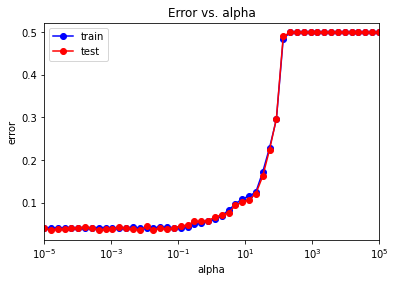

In [126]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

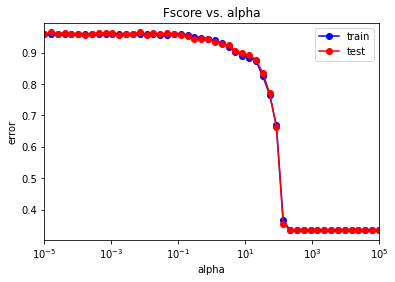

In [127]:
plt.semilogx(alpha_arr, train_f1, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_f1, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Fscore vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

### Выводы:

#### 3.1 Подбор числа нейронов в однослойном классификаторе
* Совпадение графиков Error/Fscore для train/test готорят о одинаковом распределении тренировочных и тестовых данных. 
* Переобучения нет -> в модели нет высоких весовых значений и модель достаточно простая, чтобы уметь обощаться.
* Недообучения нет -> Модель достаточно сложная, чтобы решать посталвенную задачу.
* Мы видим что при hidden_layer_size>20 наши гафики Error/Fscore выходят на плато. Поэтому не имеет смысла еще больше увеличивать число неронов в скрытом слое.
* За оптимальный размер скрытого слоя возьмем минимум ошибки и максимум Fscore на тестовой выборке 96%: hidden_layer_size=22
* Также можно заметить, что мы достигаем высокого Fscore уже при hidden_layer_size=2 -> Все входные обЪекты, которые описываются 47 признаками, могут быть спроецированы в двумерное пространство и разделены на классы с высокой точностью 93% Fscore. Можно даже построить эти графики (P.S. это будет выполнено в след. лаборатоной)

#### 3.2 Подбор числа нейронов в двухслойном классификаторе
* Интересно заметить, что можно уменьшить число обучаемых параметров модели, сохраняя точность 96% Fscore, путем использования 2 слоев с hidden_layer_size=[5, 6]. То есть в однослойном персептроне мы имели 22 нерона, а в двуслойном уже 11 - в два раз меньше.
* Если использовать схему нейронов hidden_layer_size=[1, N], то достигается максимум 90% Fscore. Поскольку после проецирование входных признаков в 1-мерное пространтсво, теряется доля полезной информации, которая в других случаях hidden_layer_size, добавляет 5% Fscore.
* Переобучения и недообучения не обнаружено.
* Использоваyние двух слоев в рамках этой задачи не дает прировтса в точности, но кменьшает число обучаемых парметров. 

#### 3.3 Подбор параметра регуляризации
* Мы наблюдаем, что с ростом коэффициента регуляризации растет ошибка и падает Fscore -> после обучения у модели не возникает больших значений весовых коэффициентов -> нет переобучения модели. Пока lambda < 0.1 мы наблюдаем сохранение точности, но при lambda>0.1 ошибка растет. И с ростом lambda, уменьшаются веса модели W->0, вплоть до того состояния когда модель ведет себя словно "мартышка" - угадывает каждый класс с вероятностью 1/k, k - число классов. 